#### machine learning preliminary experiment

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
merged = pd.read_pickle('../dataset/merged_data_2class.pkl')
merged

,sex,age,edu,end,GAF,RIN,raw_reads,clean_reads,Q20,Q30,...,EEF1A1P21,AC006380.1,AGR3,RHBDF1P1,GAPDHP67,SKOR2,AC007064.2,MAB21L4,AC006328.1,AL080248.1
id,,,,,,,,,,,,,,,,,,,,,
n337,1,14,8,0,56,8.1,7.911602,7.901730,97.24,92.79,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n342,0,17,9,0,52,9.0,7.886186,7.877051,97.52,93.32,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n346,0,17,9,0,47,8.8,7.936888,7.928224,97.39,93.09,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n348,0,21,14,0,48,8.3,7.857012,7.849438,97.24,92.78,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n349,0,18,9,1,46,8.3,7.973639,7.963862,98.07,94.73,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n442c,1,14,8,0,66,8.8,7.989200,7.983345,97.68,93.76,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n449c,0,15,9,0,72,7.9,7.994069,7.985102,97.71,93.89,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n457c,1,27,16,0,71,6.9,7.999861,7.991270,97.48,93.40,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
merged = merged.reset_index(drop=False)
merged

,id,sex,age,edu,end,GAF,RIN,raw_reads,clean_reads,Q20,...,EEF1A1P21,AC006380.1,AGR3,RHBDF1P1,GAPDHP67,SKOR2,AC007064.2,MAB21L4,AC006328.1,AL080248.1
0,n337,1,14,8,0,56,8.1,7.911602,7.901730,97.24,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,n342,0,17,9,0,52,9.0,7.886186,7.877051,97.52,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,n346,0,17,9,0,47,8.8,7.936888,7.928224,97.39,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,n348,0,21,14,0,48,8.3,7.857012,7.849438,97.24,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,n349,0,18,9,1,46,8.3,7.973639,7.963862,98.07,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,n442c,1,14,8,0,66,8.8,7.989200,7.983345,97.68,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,n449c,0,15,9,0,72,7.9,7.994069,7.985102,97.71,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,n457c,1,27,16,0,71,6.9,7.999861,7.991270,97.48,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,n465c,1,14,8,0,60,7.5,8.022328,8.013831,97.73,...,0.041761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#merged = merged.fillna(0)
from sklearn.utils import shuffle
shuffled = shuffle(merged)
shuffled = pd.read_pickle('../dataset/merged_data_shuffled_2class.pkl')
#shuffled.to_pickle('../dataset/merged_data_shuffled_2class.pkl')
labels = np.array(shuffled['end'])
features = np.array(shuffled.drop(columns=['end','id']))
print(labels.shape)
print(features.shape)

X = features
Y = labels
print(Y)

(107,)
(107, 39527)
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(mean) ACC:  0.8961038961038961 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9538520642416746
(std) ACC:  0.0477173326516204 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.029670786260060464


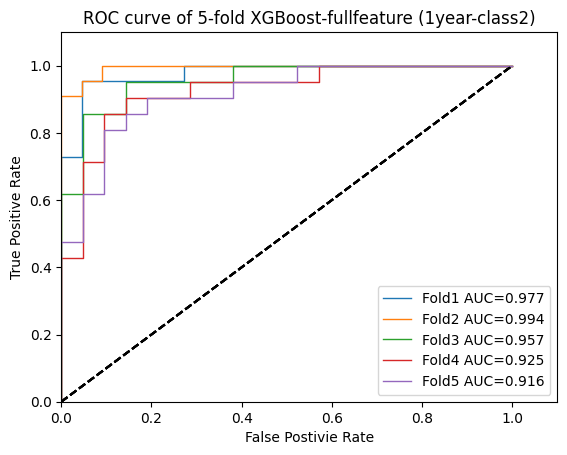

In [5]:
import xgboost as xgb
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=Y
)

# 5-fold
model_name = 'XGBoost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name + '-fullfeature (1year-class2)')
plt.savefig('../images/class2/roc-5fold-' + model_name + '-fullfeature.png',dpi=300)
plt.show()

(mean) ACC:  0.8961038961038961 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9591330747174902
(std) ACC:  0.0477173326516204 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.03434656375884797


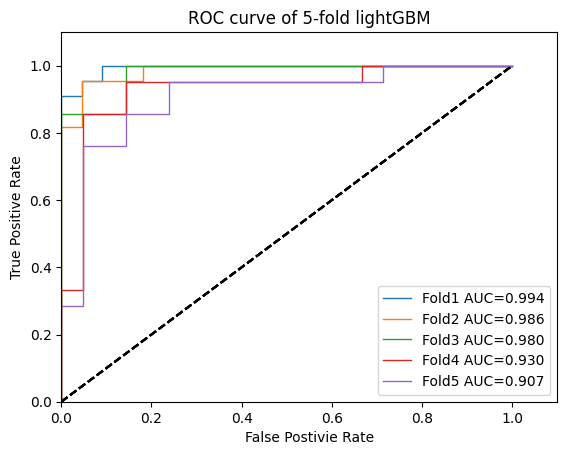

In [6]:
import lightgbm as lgb

# 5-fold
model_name = 'lightGBM'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = lgb.LGBMClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.887012987012987 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9173994115552556
(std) ACC:  0.03930583363745862 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.0547974120713742


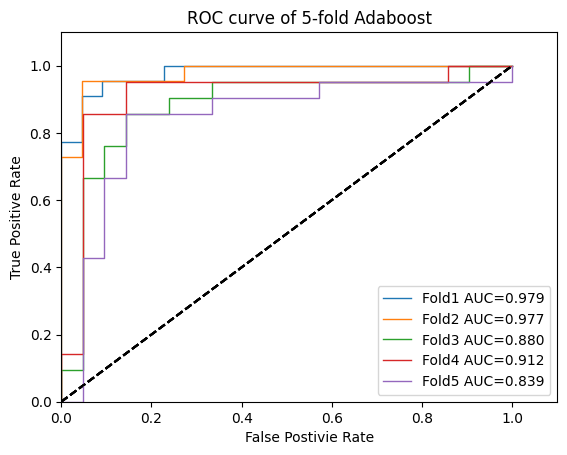

In [7]:
from sklearn.ensemble import AdaBoostClassifier

# 5-fold
model_name = 'Adaboost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = AdaBoostClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.8961038961038961 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.8880615055939731
(std) ACC:  0.0477173326516204 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.05613842616802056


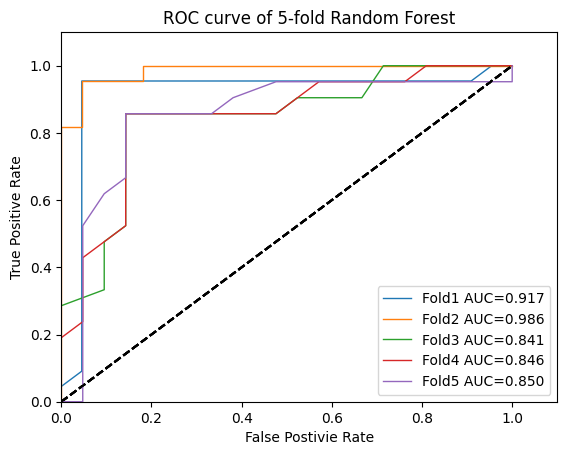

In [8]:
from sklearn.ensemble import RandomForestClassifier

# 5-fold
model_name = 'Random Forest'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = RandomForestClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.8220779220779221 Precision:  0.26666666666666666 Recall:  0.26666666666666666 F1:  0.2 AUC:  0.8220779220779221
(std) ACC:  0.06940461930331111 Precision:  0.38873012632302006 Recall:  0.38873012632302006 F1:  0.24494897427831783 AUC:  0.0694046193033111


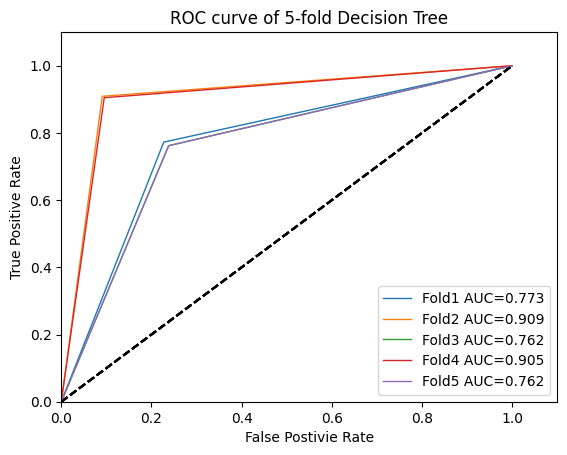

In [9]:
from sklearn.tree import DecisionTreeClassifier

# 5-fold
model_name = 'Decision Tree'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = DecisionTreeClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.6277056277056277 Precision:  0.16493506493506493 Recall:  0.6666666666666667 F1:  0.23653679653679655 AUC:  0.6480083769044808
(std) ACC:  0.08140370059596994 Precision:  0.07199890368536233 Recall:  0.29814239699997197 F1:  0.07703419110500001 AUC:  0.08244700002169163


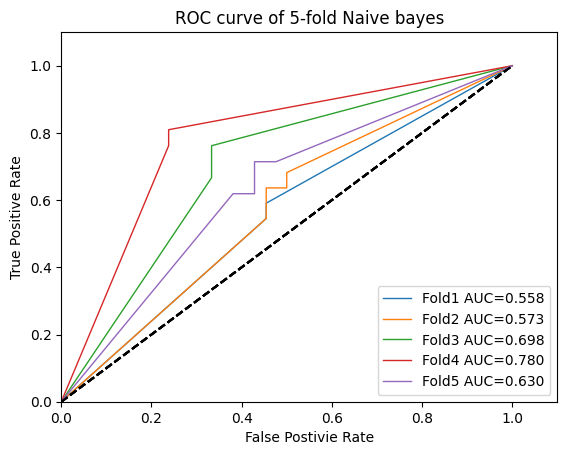

In [10]:
from sklearn.naive_bayes import GaussianNB

# 5-fold
model_name = 'Naive bayes'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = GaussianNB()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.887012987012987 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9409718708420007
(std) ACC:  0.03930583363745862 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.022740034804709392


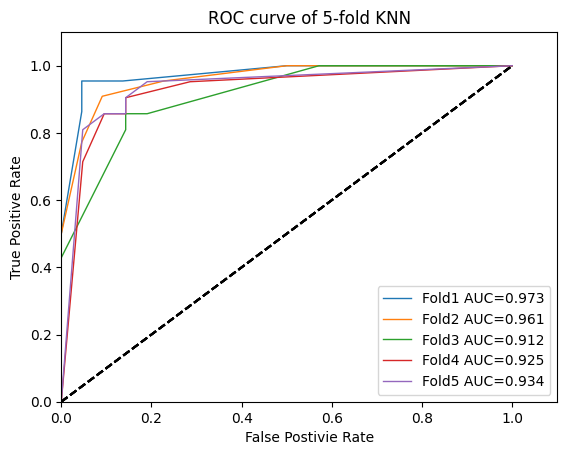

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# 5-fold
model_name = 'KNN'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = KNeighborsClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.803030303030303 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.8203289855887258
(std) ACC:  0.08015090431884411 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.07136946989069194


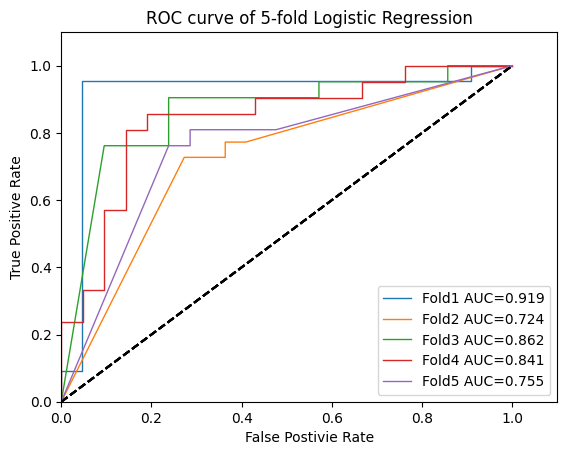

In [12]:
from sklearn.linear_model import LogisticRegression

# 5-fold
model_name = 'Logistic Regression'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = LogisticRegression()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

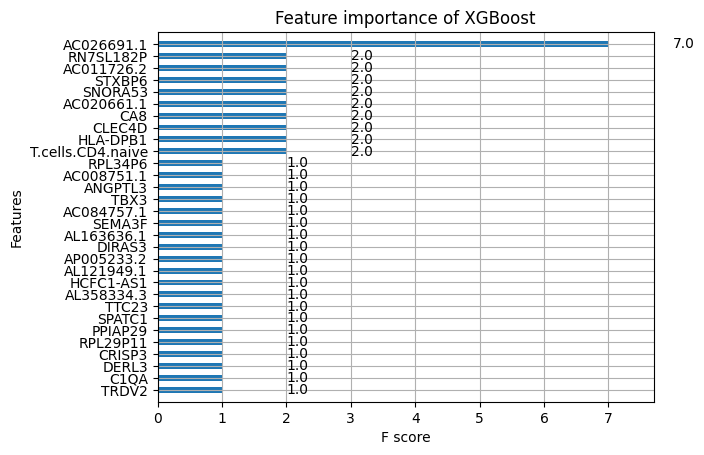

In [13]:
## feature importance
import matplotlib.pyplot as plt
%matplotlib inline

# xgboost
model_name='XGBoost'

import xgboost
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X, Y)

feature_names = merged.drop(columns=['end','id']).columns.values.tolist()
clf.get_booster().feature_names = feature_names
xgboost.plot_importance(clf, height=0.5, max_num_features=30)
plt.title('Feature importance of '  + model_name)
plt.savefig('../images/class2/feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876227
[LightGBM] [Info] Number of data points in the train set: 107, number of used features: 28077
[LightGBM] [Info] Start training from score 0.102804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

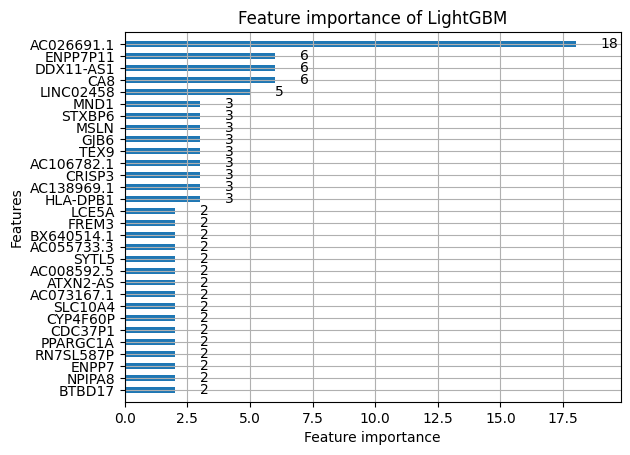

In [14]:
# lightGBM
model_name='LightGBM'
feature_names = merged.drop(columns=['end','id']).columns.values.tolist()

params = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'regression',  
    'metric': {'auc'},  
    'num_leaves': 31,  
    'learning_rate': 0.05,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 5,  
    'verbose': 1  
}

import lightgbm as lgb
train = lgb.Dataset(data=merged.drop(columns=['end','id']),label=merged['end'])
#clf = lgb.LGBMClassifier(n_jobs=-1)
clf = lgb.train(params,train)

ax = lgb.plot_importance(clf, height=0.5, max_num_features=30)
plt.title('Feature importance of '  + model_name)

plt.savefig('../images/class2/feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

In [15]:
# 3-feature
feature3 = shuffled[['AC026691.1','CA8','STXBP6','end']]
feature3

,AC026691.1,CA8,STXBP6,end
67,0.052509,0.111783,0.006565,0
21,0.244465,0.062181,0.005557,0
43,0.134586,0.023389,0.006010,0
61,0.000000,0.026329,0.006150,1
18,0.022881,0.136385,0.002861,0
...,...,...,...,...
11,0.113896,0.096986,0.007120,0
54,0.025824,0.072254,0.001614,0
80,0.161049,0.139938,0.004315,0
25,0.214220,0.169387,0.000000,0


In [16]:
y3 = np.array(feature3['end'])
x3 = np.array(feature3.drop(columns=['end']))
print(y3)

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(mean) ACC:  0.9623376623376624 Precision:  0.9 Recall:  0.7999999999999999 F1:  0.8133333333333332 AUC:  0.9898512021888646
(std) ACC:  0.018849819097036587 Precision:  0.20000000000000004 Recall:  0.16329931618554522 F1:  0.10666666666666669 AUC:  0.006294245808022426


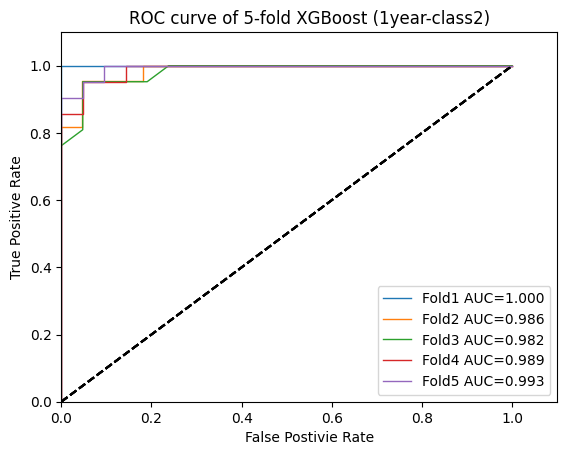

In [19]:
import xgboost as xgb

# 5-fold
model_name = 'XGBoost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(x3):
    train_x,test_x = x3[train_index], x3[valid_index]
    train_y,test_y = y3[train_index], y3[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name +  ' (1year-class2)')
plt.savefig('../images/class2/roc-5fold-' + model_name + '-3feature.png',dpi=300)
plt.show()

(mean) ACC:  0.9627705627705628 Precision:  0.8 Recall:  0.8666666666666666 F1:  0.7866666666666667 AUC:  0.9938119600457263
(std) ACC:  0.01863987025247705 Precision:  0.2449489742783178 Recall:  0.16329931618554522 F1:  0.12220201853215575 AUC:  0.005467335652654481


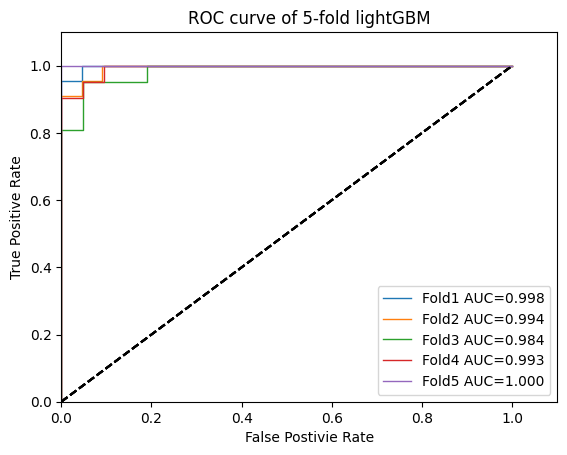

In [18]:
import lightgbm as lgb

# 5-fold
model_name = 'lightGBM'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(x3):
    train_x,test_x = x3[train_index], x3[valid_index]
    train_y,test_y = y3[train_index], y3[valid_index]
    clf = lgb.LGBMClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
plt.savefig('../images/class2/roc-5fold-' + model_name + '-3feature.png',dpi=300)
plt.show()